In [169]:
import numpy as np 
import sys
sys.path.append("../")
import pickle as pkl
import os
from pathlib import Path
import fnmatch

from glob import glob
import search_world
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [150]:
def get_data_paths(job_id=''):    
    """Returns list of scalar/vector data filenames, config filenames for a given job_id. If job_id is not specified, will return 
    all config/vector/scalar files in the logs directory. These are sorted such that correspondig scalar/vector/config
    filenames have the same index
    """
    job_id = ''
    data_dir = os.path.join('../logs/', job_id)
    config_fns = [fname for root, _, _ in os.walk(data_dir) for fname in glob(os.path.join(root, 'config.log'))]
    scalar_fns = [fname for root, _, _ in os.walk(data_dir) for fname in glob(os.path.join(root, 'scalar'))]
    vector_fns = [fname for root, _, _ in os.walk(data_dir) for fname in glob(os.path.join(root, 'vector'))]
    vector_fns.sort()
    scalar_fns.sort()
    config_fns.sort()
    return dict(
        scalar_fns=scalar_fns,
        vector_fns=vector_fns,
        config_fns=config_fns
    )

def _flatten_dict(d):
    """Flattens any nested dictionaries in dictionary d into a single-level dictionary. Only flattens a single level"""
    d_copy = {}
    t = {}
    for k, v in d.items():
        if isinstance(v, dict):
            for nested_k, nested_v in v.items():        
                d_copy.update({nested_k: nested_v})
        else:
            d_copy.update({k: v})      
    return d_copy

def get_trials_dataframe(vector_fns, scalar_fns):
    """Aggregates data for a particular job or set of jobs into a single dataframe, where each row corresponds to a trial"""
    # NOTE: This method is and should generally be task-specific, since the way we break up steps into trials should also be trial-specific
    vector_dfs = []
    scalar_dicts = []
    for dataset_index, (vector_fn, scalar_fn) in enumerate(zip(vector_fns, scalar_fns)):
        with open(scalar_fn, 'rb') as f:
            scalar_dict = pkl.load(f) # this dict will likely contain the output of the info methods for both the model and the environment for a particular task, 
            # but the exact content depends on the script being used to run the simulations
            scalar_dict.update({'dataset_index': dataset_index})
        # TODO: Remove following lines. Should be done in trainer.py 
        scalar_dict.update(scalar_dict['env']._maze_gen_func_kwargs)
        scalar_dict.update(scalar_dict['env'].info())
        scalar_dict.update(scalar_dict['model'].info())
        scalar_dicts.append(scalar_dict)
        with open(vector_fn, 'rb') as f:
            vector_dicts = pkl.load(f)
            for d in vector_dicts:
                d = _flatten_dict(d)
            df = pd.DataFrame(vector_dicts)
            df['dataset_index'] = dataset_index
            # this is task-specific, but for most tasks will likely work in this manner - finding the timestep at which done is set to True
            df['trial_index'] = df.done.cumsum().shift(fill_value=0)


            # changes are columns to collapse (values should change during a trial)
            # constants are columns that stay the same during a trial
            constants = ['job_id', 'trial_index', 'dataset_index']            
            changes = df.columns.difference(constants).tolist()

            f = lambda x: x.tolist() if len(x) > 1 else x

            # flattening dataframe into trial rows
            df = df.groupby(constants)[changes].agg(f).reset_index()

            # makes done value a list (convenient for removing trials that never ended)
            df['done'] = df.done.apply(lambda x: [x] if isinstance(x, bool) else x)

            # removing trials that never ended
            df = df[df.apply(lambda x: True in x.done, axis=1)].reset_index()

            vector_dfs.append(df)

    scalar_df = pd.DataFrame(scalar_dicts)
    
    df = pd.concat(vector_dfs).reset_index()
    
    df = df.merge(scalar_df, on='dataset_index')
    
    return df     

def get_trials_features(df):
    """Given a dataframe of trials, returns updated trials with new features extracted from raw data. TASK SPECIFIC"""
    df = df.copy()
    df['agent_dist'] = df.apply(lambda x: len(x.action) - 1, axis=1)
    df['agent_error'] = 1 - df.min_dist/df.agent_dist
    return df

def get_consistency(df, condition, group_1_func, group_2_func, metric, suffixes):
    suffixes_1 = [suffixes[0] + '_split_1', suffixes[0] + '_split_2']
    suffixes_2 = [suffixes[1] + '_split_1', suffixes[1] + '_split_2']
    group_1_consistency_dict = get_self_consistency(df=df, condition=condition, group_func=group_1_func, metric=metric, suffixes=suffixes_1)
    group_2_consistency_dict = get_self_consistency(df=df, condition=condition, group_func=group_2_func, metric=metric, suffixes=suffixes_2)
    df = df.copy()
    df1 = df[df.apply(group_1_func, axis=1)]
    df2 = df[df.apply(group_2_func, axis=1)]
    condition_metric_df1 = df1.groupby(condition)[metric].mean().to_frame()
    condition_metric_df2 = df2.groupby(condition)[metric].mean().to_frame()
    merged = condition_metric_df1.merge(condition_metric_df2, on=condition, suffixes=suffixes)
    cross_corr = merged[metric + suffixes[0]].corr(merged[metric + suffixes[1]])
    cross_corr = cross_corr / np.sqrt(np.mean(group_1_consistency_dict['corr']) * np.mean(group_2_consistency_dict['corr']))
    return dict(
        group_1_consistency_dict=group_1_consistency_dict,
        group_2_consistency_dict=group_2_consistency_dict,
        corr=cross_corr,
        df=merged        
    )

def mask(n, p=0.5):
    a = np.zeros(n, dtype=int)
    a[:int(p * n)] = 1
    np.random.shuffle(a)
    a = a.astype(bool)
    return a

def get_self_consistency(df, condition, group_func, metric, suffixes, num_iterations=1):
    df = df.copy()
    df = df[df.apply(group_func, axis=1)]
    df = df.set_index(condition) 
    grouped_df = df.groupby(condition)
    corr = []
    for i in range(num_iterations):
        masks = grouped_df.index.agg('count').agg(lambda x: mask(x)).to_frame()
        df1 = grouped_df.apply(lambda x: x[masks.loc[x.index[0]][0]])
        df2 = grouped_df.apply(lambda x: x[~masks.loc[x.index[0]][0]])
        condition_metric_df1 = df1.groupby(condition)[metric].mean().to_frame()
        condition_metric_df2 = df2.groupby(condition)[metric].mean().to_frame()
        merged = condition_metric_df1.merge(condition_metric_df2, on=condition, suffixes=suffixes)
        corr.append(merged[metric + suffixes[0]].corr(merged[metric + suffixes[1]]))
    return dict(
        corr=corr,
        df=merged        
    )


def plot_scores(consistency_df, metric, suffixes):
    sns.scatterplot(data=consistency_df, x=metric+suffixes[0], y=metric+suffixes[1])    
    
   

In [151]:
fns_dict = get_data_paths()
vector_fns = fns_dict['vector_fns']
scalar_fns = fns_dict['scalar_fns']


vector_fns = vector_fns
scalar_fns = scalar_fns
df = get_trials_dataframe(vector_fns=vector_fns, scalar_fns=scalar_fns)
df = get_trials_features(df)

# Agent performance

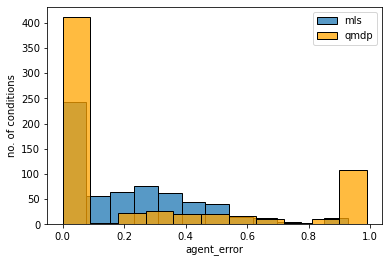

In [167]:
f, ax = plt.subplots(1,1)
mls_score_df = consistency_dict['group_1_consistency_dict']['df'][['agent_error_mls_split_1', 'agent_error_mls_split_2']]
mls_score_df['agent_error'] = mls_score_df.mean(axis=1)
qmdp_score_df = consistency_dict['group_2_consistency_dict']['df'][['agent_error_qmdp_split_1', 'agent_error_qmdp_split_2']]
qmdp_score_df['agent_error'] = qmdp_score_df.mean(axis=1)

sns.histplot(data=mls_score_df, x='agent_error', label='mls',ax=ax)
sns.histplot(data=qmdp_score_df, x='agent_error', label='qmdp',ax=ax,color='orange')
ax.set_ylabel('no. of conditions')
plt.legend()
plt.show()
# sns.lineplot(data=qmdp_score_df, x='length', y='agent_score', estimator='mean', ci="sd", label='qmdp', ax=ax)

In [172]:
mls_score_df['agent_error'].mean()
qmdp_score_df['agent_error'].mean()

0.24910987301517384

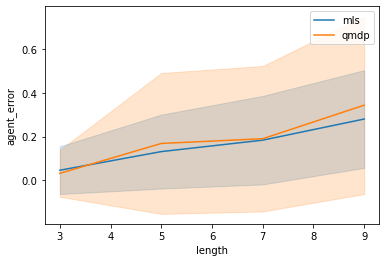

In [168]:
f, ax = plt.subplots(1,1)
# mls_score_df = consistency_dict['group_1_consistency_dict']['df'][['agent_score_mls_split_1', 'agent_score_mls_split_2']]
# mls_score_df['agent_error'] = mls_score_df.mean(axis=1)

sns.lineplot(data=mls_score_df, x='length', y='agent_error', estimator='mean',ci="sd", label='mls', ax=ax)

# qmdp_score_df = consistency_dict['group_2_consistency_dict']['df'][['agent_score_qmdp_split_1', 'agent_score_qmdp_split_2']]
# qmdp_score_df['agent_error'] = qmdp_score_df.mean(axis=1)

sns.lineplot(data=qmdp_score_df, x='length', y='agent_error', estimator='mean', ci="sd", label='qmdp', ax=ax)

plt.show()

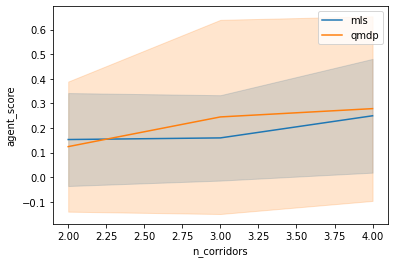

In [138]:
f, ax = plt.subplots(1,1)
mls_score_df = consistency_dict['group_1_consistency_dict']['df'][['agent_score_mls_split_1', 'agent_score_mls_split_2']]
mls_score_df['agent_error'] = mls_score_df.mean(axis=1)

sns.lineplot(data=mls_score_df, x='n_corridors', y='agent_score', estimator='mean',ci="sd", label='mls', ax=ax)

qmdp_score_df = consistency_dict['group_2_consistency_dict']['df'][['agent_score_qmdp_split_1', 'agent_score_qmdp_split_2']]
qmdp_score_df['agent_error'] = qmdp_score_df.mean(axis=1)

sns.lineplot(data=qmdp_score_df, x='n_corridors', y='agent_score', estimator='mean', ci="sd", label='qmdp', ax=ax)

plt.show()

# Within-agent consistency

In [ ]:
suffixes = ['_mls_split_1', '_mls_split_2']
def mls_func(x): return x['name'] == 'MLSAgent'
# list of columns whose values define a unique condition
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
consistency_dict = get_self_consistency(df=df, condition=condition, group_func=mls_func,
                                   metric='agent_error', suffixes=suffixes, num_iterations=10)


MLS self-consistency: 0.86 ± 0.01


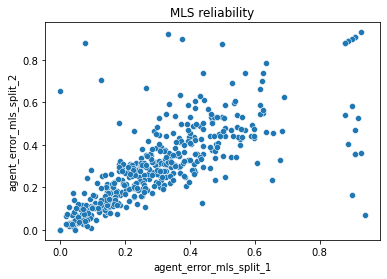

In [154]:
plot_scores(consistency_df=consistency_dict['df'], metric='agent_error', suffixes=suffixes)
plt.title('MLS reliability')
print('MLS self-consistency: %.2f ± %.2f' % (np.mean(consistency_dict['corr']), np.std(consistency_dict['corr'])))

In [155]:
suffixes = ['_qmdp_split_1', '_qmdp_split_2']
def qmdp_func(x): return x['name'] == 'QMDPAgent'
# list of columns whose values define a unique condition
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
consistency_dict = get_self_consistency(df=df, condition=condition, group_func=qmdp_func,
                                   metric='agent_error', suffixes=suffixes, num_iterations=10)

QMDP self-consistency: 0.97 ± 0.00


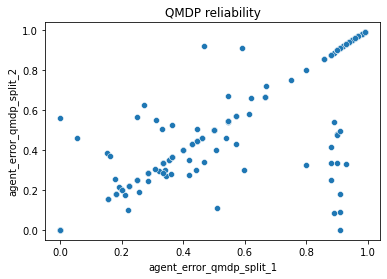

In [156]:
plot_scores(consistency_df=consistency_dict['df'], metric='agent_error', suffixes=suffixes)
plt.title('QMDP reliability')
print('QMDP self-consistency: %.2f ± %.2f' % (np.mean(consistency_dict['corr']), np.std(consistency_dict['corr'])))

# Cross-agent consistency scores

In [173]:
def mls_func(x): return x['name'] == 'MLSAgent'
def qmdp_func(x): return x['name'] == 'QMDPAgent'
suffixes = ['_mls', '_qmdp']
# list of columns whose values define a unique condition
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
corrs = []
for i in range(10):
    consistency_dict = get_consistency(df=df, condition=condition, group_1_func=mls_func, group_2_func=qmdp_func,
                                       metric='agent_error', suffixes=suffixes)
    corrs.append(consistency_dict['corr'])


In [174]:
print(np.mean(corrs), np.std(corrs))

0.6892473559662268 0.004864868652157718


MLS-QMDP consistency: 0.70


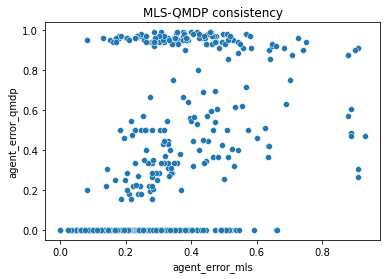

In [163]:
print('MLS-QMDP consistency: %.2f' % consistency_dict['corr'])
plot_scores(consistency_df=consistency_dict['df'], metric='agent_error', suffixes=suffixes)
plt.title('MLS-QMDP consistency')
plt.show()

# OLD

In [25]:
# TODO: Find number of trials per condition
# TODO: Find agent score on each trial 
df = all_df[all_df['name'] == 'MLSAgent']
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
print(df.columns)
df = df.set_index(condition) # grouping by initial condition and maze configuratio
# TODO: Splitting dataframe into two datasets per condition
grouped_df = df.groupby(condition)
def mask(n, p=0.5):
    a = np.zeros(n, dtype=int)
    a[:int(p * n)] = 1
    np.random.shuffle(a)
    a = a.astype(bool)
    return a
masks = grouped_df.index.agg('count').agg(lambda x: mask(x)).to_frame()
df1 = grouped_df.apply(lambda x: x[masks.loc[x.index[0]][0]])
df2 = grouped_df.apply(lambda x: x[~masks.loc[x.index[0]][0]])
# TODO: Average scores across trials with the same condition
condition_scores_df1 = df1.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
condition_scores_df2 = df2.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
# TODO: Repeat this to do multi-step cross validation
# TODO: Compare average scores across trials of different agents
merged = condition_scores_df1.merge(condition_scores_df2, on=['length', 'n_corridors', 'agent_initial_position', 'target_position'])
print('MLS correlation: %.2f' % merged.agent_score_x.corr(merged.agent_score_y))
mls_corr = merged.agent_score_x.corr(merged.agent_score_y)

Index(['level_0', 'index', 'job_id', 'trial_index', 'dataset_index', 'action',
       'done', 'info', 'obs', 'reward', 'step', 'env', 'model', 'min_dist',
       'max_dist', 'name', 'horizon', 'lambda', 'agent_dist', 'agent_score'],
      dtype='object')


KeyError: "None of ['length', 'n_corridors', 'agent_initial_position', 'target_position'] are in the columns"

In [252]:
# TODO: Find number of trials per condition
# TODO: Find agent score on each trial 
df = all_df[all_df.name == 'QMDPAgent']
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
df = df.set_index(condition) # grouping by initial condition and maze configuratio
# TODO: Splitting dataframe into two datasets per condition
grouped_df = df.groupby(condition)
def mask(n, p=0.5):
    a = np.zeros(n, dtype=int)
    a[:int(p * n)] = 1
    np.random.shuffle(a)
    a = a.astype(bool)
    return a
masks = grouped_df.index.agg('count').agg(lambda x: mask(x)).to_frame()
df1 = grouped_df.apply(lambda x: x[masks.loc[x.index[0]][0]])
df2 = grouped_df.apply(lambda x: x[~masks.loc[x.index[0]][0]])
# TODO: Average scores across trials with the same condition
condition_scores_df1 = df1.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
condition_scores_df2 = df2.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
# TODO: Repeat this to do multi-step cross validation
# TODO: Compare average scores across trials of different agents
merged = condition_scores_df1.merge(condition_scores_df2, on=['length', 'n_corridors', 'agent_initial_position', 'target_position'])
print('QMDP correlation: %.2f' % merged.agent_score_x.corr(merged.agent_score_y))
qmdp_corr = merged.agent_score_x.corr(merged.agent_score_y)

QMDP correlation: 0.97


In [20]:
# Finding cross agent correlation
# TODO: Find number of trials per condition
# TODO: Find agent score on each trial 
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
df = df.set_index(condition) # grouping by initial condition and maze configuration
# TODO: Splitting dataframe into two datasets per condition
df_mls = df[df.name == 'MLSAgent']
df_qmdp = df[df.name == 'QMDPAgent']

condition_scores_df_mls = df_mls.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
condition_scores_df_qmdp = df_qmdp.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
# TODO: Repeat this to do multi-step cross validation
# TODO: Compare average scores across trials of different agents
merged = condition_scores_df_mls.merge(condition_scores_df_qmdp, on=['length', 'n_corridors', 'agent_initial_position', 'target_position'], suffixes=('_mls', '_qmdp'))

cross_corr = merged.agent_score_mls.corr(merged.agent_score_qmdp)
print('Cross-agent correlation: %.2f' % (cross_corr/(np.sqrt(qmdp_corr * mls_corr))))

NameError: name 'qmdp_corr' is not defined

<AxesSubplot:xlabel='agent_score_mls', ylabel='agent_score_qmdp'>

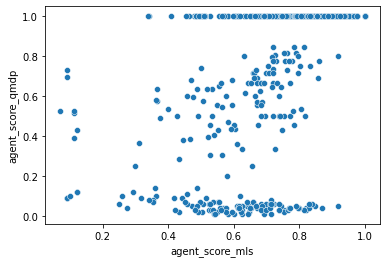

In [257]:
sns.scatterplot(x='agent_score_mls', y='agent_score_qmdp', data=merged)

Seeing for which conditions the agent scores differ the most

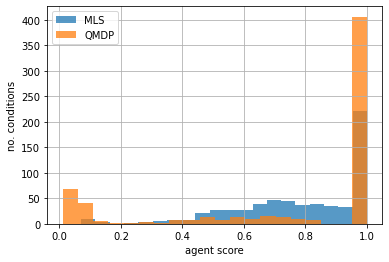

In [258]:
merged.agent_score_mls.hist(label='MLS', alpha=0.75, bins=20)
merged.agent_score_qmdp.hist(label='QMDP', alpha=0.75, bins=20)
plt.legend()
plt.ylabel('no. conditions')
plt.xlabel('agent score')
plt.show()

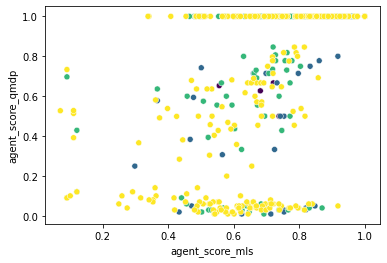

In [259]:
sns.scatterplot(x='agent_score_mls', y='agent_score_qmdp', c=merged.reset_index().length, data=merged, legend=True)
plt.show()

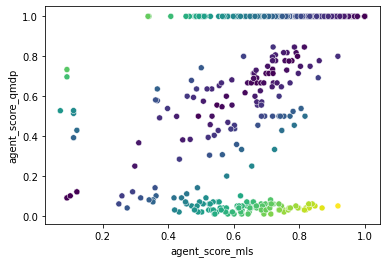

In [261]:
sns.scatterplot(x='agent_score_mls', y='agent_score_qmdp', c=merged.score_diff, data=merged, legend=True, cmap='viridis')
plt.show()

In [260]:
merged['score_diff'] = np.abs(merged.agent_score_qmdp/merged.agent_score_qmdp.max() - merged.agent_score_mls/merged.agent_score_mls.max())
merged['score_diff'] = merged['score_diff']/merged['score_diff'].max()

In [201]:
print(merged.score_diff.corr(merged['length']))
print(merged.score_diff.corr(merged['n_corridors']))

0.28866877345182745
0.06927391857489822
